# ML Workbench Sample --- Image Classification

<br><br>
### _Introduction of ML Workbench_
ML Workbench provides an easy command line interface for machine learning life cycle, which involves four stages:
* analyze: gather stats and metadata of the training data, such as numeric stats, vocabularies, etc. Analysis results are used in transforming raw data into numeric features, which can be consumed by training directly.  
* transform: explicitly transform raw data into numeric features which can be used for training.
* train: training model using transformed data.
* predict/batch_predict: given a few instances of prediction data, make predictions instantly / with large number of instances of prediction data, make predictions in a batched fassion.


There are "local" and "cloud" run mode for each stage. "cloud" run mode is recommended if your data is big.
<br><br>
ML Workbench supports numeric, categorical, text, image training data. For each type, there are a set of "transforms" to choose from. The "transforms" indicate how to convert the data into numeric features. For images, it is converted to fixed size vectors representing high level features.
<br><br>

### _Transfer learning using ML Workbench - Local Run Experience_
ML Workbench supports image transforms (image to vec) with transfer learning.

Traditionally, image classification required a very large corpus of training data - often millions of images which may not be available and a long time to train on those images which is expensive and time consuming. That has changed with transfer learning which can be readily used with Cloud ML Engine and without deep knowledge of image classification algorithms using the ML Workbench in Datalab.

This notebook codifies the capabilities discussed in this [blog post](https://cloud.google.com/blog/big-data/2016/12/how-to-train-and-classify-images-using-google-cloud-machine-learning-and-cloud-dataflow). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. The pre-trained model is used to generate numeric features (image_to_vec transform). For explanation, simple flower images are used. Compared to training from scratch, the training data requirements, time and costs are drastically reduced.

This notebook does all operations in the Datalab container without calling CloudML API. Hence, this is called "local" operations - though Datalab itself is most often running on a GCE VM. See the corresponding cloud notebook for cloud experience which only adds the --cloud parameter and some config to the local experience commands. The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

In [37]:
# ML Workbench magics (%%ml) are under google.datalab.contrib namespace. It is not enabled by default and you need to import it before use.
import google.datalab.contrib.mlworkbench.commands

## Setup
All data is available under gs://cloud-datalab/sampledata/flower. eval100 is a subset of eval300, which is a subset of eval670. Same for training data.

In [38]:
!mkdir -p ./flower/data
!mkdir -p ./flower/images
!gsutil -m cp gs://cloud-datalab/sampledata/flower/* ./flower/data

Copying gs://cloud-datalab/sampledata/flower/all.csv...
Copying gs://cloud-datalab/sampledata/flower/eval300.csv...
Copying gs://cloud-datalab/sampledata/flower/eval670.csv...
Copying gs://cloud-datalab/sampledata/flower/eval100.csv...
Copying gs://cloud-datalab/sampledata/flower/train200.csv...
Copying gs://cloud-datalab/sampledata/flower/train300.csv...
Copying gs://cloud-datalab/sampledata/flower/train1000.csv...
Copying gs://cloud-datalab/sampledata/flower/train3000.csv...


In order to get best efficiency, we download the images to local disk, and create our training and evaluation files to reference local path instead of GCS path. Note that the original training files referencing GCS image paths work too, although a bit slower.

In [39]:
import csv
import datalab.storage as gcs
import os


def download_images(input_csv, output_csv, images_dir):
    with open(input_csv) as csvfile:
        data = list(csv.DictReader(csvfile, fieldnames=['image_url', 'label']))
    for x in data:
        url = x['image_url']
        out_file = os.path.join(os.path.abspath(images_dir), os.path.basename(url))
        with open(out_file, 'w') as f:
          f.write(gcs.Item.from_url(url).read_from())
        x['image_url'] = out_file

    with open(output_csv, 'w') as w:
        csv.DictWriter(w, fieldnames=['image_url', 'label']).writerows(data)


download_images('./flower/data/train200.csv', './flower/data/localtrain.csv', './flower/images')    
download_images('./flower/data/eval100.csv', './flower/data/localeval.csv', './flower/images')

The above code can best be illustrated by the comparison below.

In [40]:
!head ./flower/data/train200.csv -n 5

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy


In [41]:
!head ./flower/data/localtrain.csv -n 5

Define the dataset (train/eval, their schema, format) which will be used in model training. ML Workbench supports csv file paths or bigquery tables. Run "%%ml dataset --help" for details.

In [42]:
%%ml dataset create
format: csv
schema:
    - name: image_url
      type: STRING
    - name: label
      type: STRING
name: flower_local
train: ./flower/data/localtrain.csv
eval: ./flower/data/localeval.csv

# Analyze

Analysis step includes computing numeric stats (i.e. min/max), categorical classes, text vocabulary and frequency, etc. Run "%%ml analyze --help" for usage. The analysis results will be used for transforming raw data into numeric features that the model can deal with. For example, to convert categorical value to a one-hot vector ("Monday" becomes [1, 0, 0, 0, 0, 0, 0]). The data may be very large, so sometimes a cloud run is needed by adding --cloud flag.  

In this case, analysis step only collects unique labels.

Note that we run analysis only on training data, but not evaluation data.

For help, run "%%ml analyze --help".

In [43]:
%%ml analyze
output: ./flower/analysis
data: flower_local
features:
    image_url:
        transform: image_to_vec
    label:
        transform: target

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/docs/samples/contrib/mlworkbench/image_classification_flower/flower/data/localtrain.csv...
file /content/datalab/docs/samples/contrib/mlworkbench/image_classification_flower/flower/data/localtrain.csv analyzed.


In [44]:
!ls ./flower/analysis

features.json  schema.json  stats.json	vocab_label.csv


# Transform

With analysis results we can transform raw data into numeric features. This needs to be done for both training and eval data. The data may be very large, so sometimes a cloud pipeline is needed by adding --cloud.

In this case where image data exists, transform is required. It downloads image, resizes it, and generate embeddings from each image by running a pretrained TensorFlow graph.

In [45]:
# Delete existing transform output data
!rm -r -f ./flower/transform

Transform training data.

In [46]:
%%ml transform
analysis: ./flower/analysis
output: ./flower/transform
data: flower_local

Converted 376 variables to const ops.
Converted 376 variables to const ops.


In [47]:
!ls ./flower/transform -l -h

total 2.2M
-rw-r--r-- 1 root root    0 Oct 19 20:30 errors_eval-00000-of-00001.txt
-rw-r--r-- 1 root root    0 Oct 19 20:30 errors_train-00000-of-00001.txt
-rw-r--r-- 1 root root 718K Oct 19 20:30 eval-00000-of-00001.tfrecord.gz
-rw-r--r-- 1 root root 1.5M Oct 19 20:30 train-00000-of-00001.tfrecord.gz


In next cell, we create another dataset pointing to these transformed files (format is "transformed") for training.

In [48]:
%%ml dataset create
name: flower_local_transformed
format: transformed
train: ./flower/transform/train-*
eval: ./flower/transform/eval-*

# Train

Training starts from transformed data. If training work is too much to do on the local VM, --cloud is recommended so training happens in cloud, in a distributed way. Run "%%ml train --help" for details. Note that once training started, a Tensorboard instance is automatically started for you.

In [49]:
# Removing existing training files if exist.
!rm -r -f ./flower/train

In [50]:
%%ml train
output: ./flower/train
analysis: ./flower/analysis
data: flower_local_transformed
model_args:
    model: dnn_classification
    hidden-layer-size1: 100
    top-n: 0

TensorBoard was started successfully with pid 39798. Click here to access it.

Converted 376 variables to const ops.
Converted 376 variables to const ops.


# Prediction

There are two types of prediction: instant and batch. Instant prediction works for small instances of data and the results come back instantly. The prediction data is provided in http request (cloud run) or in input cell (local run).

ML Workbench provides an easy prediction client. (Run "%%ml predict --help" for usage)

daisy,dandelion,predicted,roses,sunflowers,tulips,image_url,image_url_image
9.999998e-01,1.385750e-09,daisy,1.021211e-14,1.898738e-07,1.540655e-10,./flower/images/15207766_fc2f1d692c_n...,
9.999993e-01,1.336349e-07,daisy,1.107545e-14,6.254338e-07,5.237676e-10,./flower/images/5853276960_d08f90fff6...,
2.705396e-10,2.196271e-08,tulips,1.172701e-06,1.646052e-11,9.999988e-01,./flower/images/13857267684_d2a4b2630...,
1.024843e-16,6.168276e-16,roses,1.000000e+00,7.333545e-10,3.671895e-09,./flower/images/6111589202_8b9555364c...,
4.245350e-10,1.000000e+00,dandelion,2.893184e-10,2.973896e-10,7.377875e-11,./flower/images/2634665077_597910235f...,
3.314329e-12,1.000000e+00,dandelion,1.621107e-14,7.538476e-14,1.366652e-12,./flower/images/8980164828_04fbf64f79...,
5.362015e-12,1.098789e-09,tulips,6.009899e-04,1.263113e-11,9.993991e-01,./flower/images/3705716290_cb7d803130...,
3.035795e-09,4.907312e-06,tulips,2.744949e-07,1.357259e-10,9.999949e-01,./flower/images/6876631336_54bf150990...,

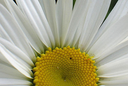
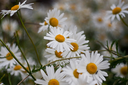
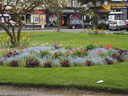
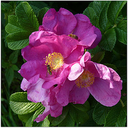
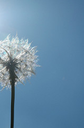
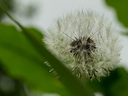
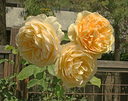
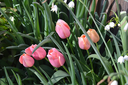

In [51]:
%%ml predict
model: ./flower/train/model
data:
  - ./flower/images/15207766_fc2f1d692c_n.jpg
  - ./flower/images/5853276960_d08f90fff6.jpg
  - ./flower/images/13857267684_d2a4b2630f_n.jpg
  - ./flower/images/6111589202_8b9555364c_m.jpg
  - ./flower/images/2634665077_597910235f_m.jpg
  - ./flower/images/8980164828_04fbf64f79_n.jpg
  - ./flower/images/3705716290_cb7d803130_n.jpg
  - ./flower/images/6876631336_54bf150990.jpg

# Batch Prediction

Batch prediction performs prediction in a batched fashion. The data can be large, and is specified by files.  

Note that, we use the "evaluation_model" which sits in "evaluation_model_dir". There are two models created in training. One is a regular model under "model" dir, the other is "evaluation_model". The difference is the regular one takes prediction data without target and the evaluation model takes data with target and output the target as is. So evaluation model is good for evaluating the quality of the model because the targets and predicted values are included in output.

In [52]:
%%ml batch_predict
model: ./flower/train/evaluation_model
output: ./flower/prediction
format: csv
batch_size: 20
data:
  csv: ./flower/data/localeval.csv

local prediction...
INFO:tensorflow:Restoring parameters from ./flower/train/evaluation_model/variables/variables
done.


Check prediction results.

In [53]:
!ls ./flower/prediction

predict_results_localeval.csv  predict_results_schema.json


We can view some metrics by "%%ml evaluate" commands.

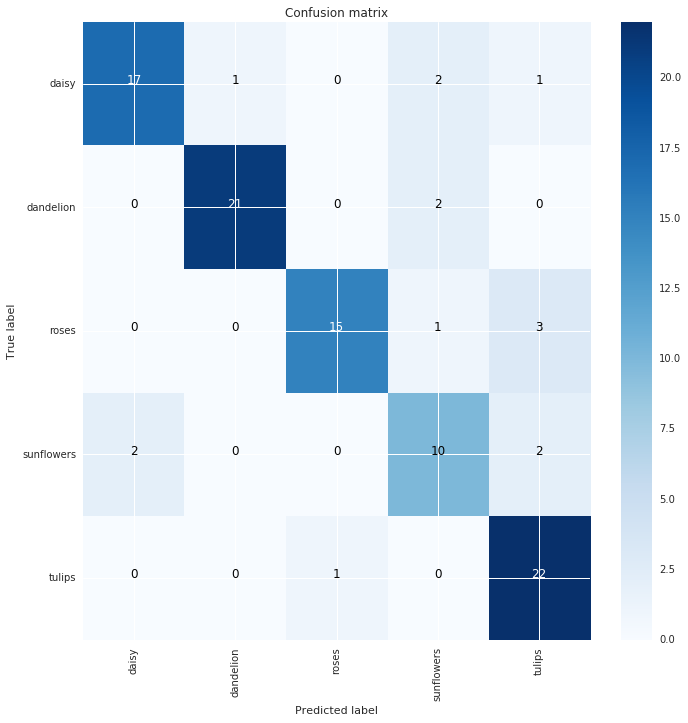

In [54]:
%%ml evaluate confusion_matrix --plot
csv: ./flower/prediction/predict_results_localeval.csv

In [55]:
%%ml evaluate accuracy
csv: ./flower/prediction/predict_results_localeval.csv

,accuracy,count,target
0,0.809524,21,daisy
1,0.913043,23,dandelion
2,0.789474,19,roses
3,0.714286,14,sunflowers
4,0.956522,23,tulips
5,0.850000,100,_all


## Why Does My Model Predict this? Prediction Explanation.

"%%ml explain" gives you insights on what are important features in the prediction data that contribute positively or negatively to certain labels. We use LIME under "%%ml explain". ([LIME](https://github.com/marcotcr/lime) is an open sourced library performing feature sensitivity analysis. It is based on the work presented in [this paper](https://arxiv.org/abs/1602.04938). LIME is included in Datalab.)

In this case, we will check which areas in a picture are contributing most to the predicted label. 

Data for the cell below:
- Path: ./flower/images/15207766_fc2f1d692c_n.jpg
- Target: daisy   
- Predicted: daisy   

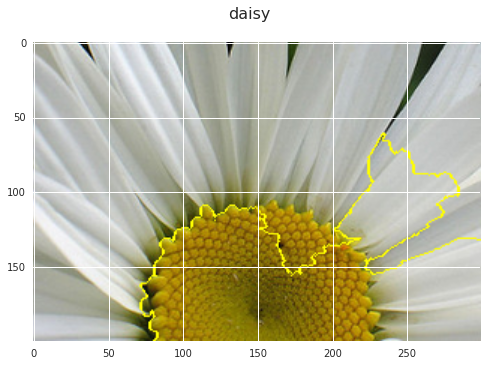

In [56]:
%%ml explain
type: image
model: ./flower/train/model
labels: daisy
data: ./flower/images/15207766_fc2f1d692c_n.jpg

Note the highlighted area!

Data for the cell below: 
- Path: ./flower/images/6111589202_8b9555364c_m.jpg   
- Target: roses   
- Predicted: roses   

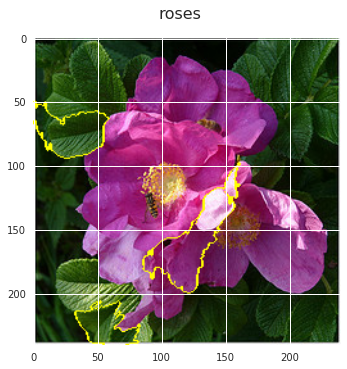

In [57]:
%%ml explain
type: image
model: ./flower/train/model
labels: roses
data: ./flower/images/6111589202_8b9555364c_m.jpg

Data for the cell below: 
- Path: ./flower/images/6876631336_54bf150990.jpg 
- Target: tulips   
- Predicted: tulips 

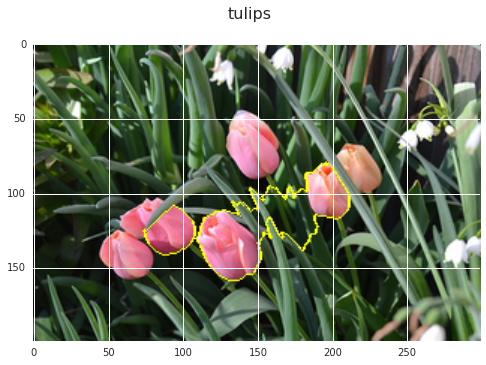

In [58]:
%%ml explain
type: image
model: ./flower/train/model
labels: tulips
data: ./flower/images/6876631336_54bf150990.jpg

The next instance prediction results are incorrect. Truth is "roses" but it predicts "tulips". Let's analyze both true label and predicted label. The green areas are "positive" areas and the red areas are "negative".

Data for the cell below: 
- Path: ./flower/images/3705716290_cb7d803130_n.jpg 
- Target: roses   
- Predicted: tulips 

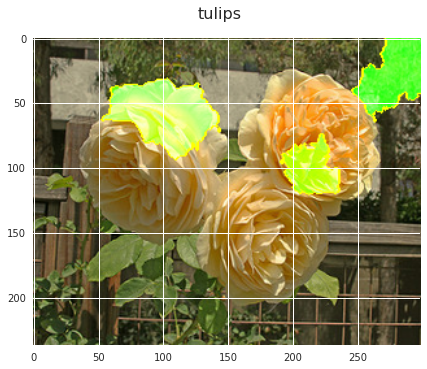

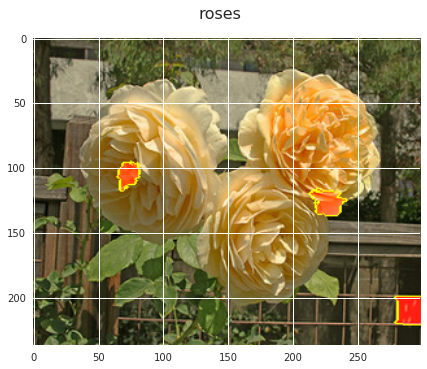

In [59]:
%%ml explain
type: image
model: ./flower/train/model
labels: tulips,roses
include_negative: true
data: ./flower/images/3705716290_cb7d803130_n.jpg

From above results, the top 3 areas for roses are all "negative", which lead the model away from predicting the truth "roses". 

# Model Deployment for Online Serving

Models, whether trained locally or from cloud, can be deployed online for serving prediction requests. Models are deployed to a GCP project. Using Datalab's model API, Datalab's project id (set by "%datalab project set -p your-project-id") is used by default. Also, please make sure the target project is enabled for Machine Learning API.

In [60]:
# Make sure the model files exist
!ls ./flower/train/model

assets.extra  saved_model.pb  variables


In [61]:
# Create the bucket if not exist
!gsutil mb gs://flower-datalab-demo-bucket

# Copy model files
!gsutil cp -R ./flower/train/model gs://flower-datalab-demo-bucket

Creating gs://flower-datalab-demo-bucket/...
Copying file://./flower/train/model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./flower/train/model/assets.extra/features.json [Content-Type=application/json]...
Copying file://./flower/train/model/assets.extra/schema.json [Content-Type=application/json]...
Copying file://./flower/train/model/variables/variables.index [Content-Type=application/octet-stream]...
/ [4 files][ 83.6 MiB/ 83.6 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://./flower/train/model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
\
Operation completed over 5 objects/87.8 MiB.                                     


In [62]:
%%ml model deploy
name: flower.alpha
path: gs://flower-datalab-demo-bucket/model

Waiting for operation "projects/bradley-playground/operations/create_flower_alpha-1508445434811"
Done.


To build such a prediction client, it takes a few steps.

1. The models trained by ML Workbench take CSV lines as input. One CSV line is one instance. We need to create CSV lines out of prediction data (pandas DataFrame or list of dictionary). The order of fields matters and it has to match the training data's schema. <br><br>

2. For image columns (containing image urls or PIL Images), we need to get the bytes, resize it (models will resize it to 299x299x3 anyway), and then convert them to base64 url-safe encoded strings and embed them in CSV lines. That's what models expect.<br><br>

3. Create an HTTP Request that will be sent for online prediction. <br><br>

In [63]:
# Encode images as base64 strings and create CSV lines, although in this case there is only one column and no need to use csv writer.

import base64
from io import BytesIO
from PIL import Image

# Here is our prediction data, in the form of list of dictionary.
my_prediction_data = [
    {'image_url': '/content/datalab/tmp/flower/images/15207766_fc2f1d692c_n.jpg'},
    {'image_url': '/content/datalab/tmp/flower/images/13857267684_d2a4b2630f_n.jpg'},
]

# Open file, resize, and base64 encoding
prediction_data_images_embedded = []
for instance in my_prediction_data:
    with open(instance['image_url'], 'r') as f_image:
          im = Image.open(f_image)
          im.thumbnail((299, 299), Image.ANTIALIAS)
          buf = BytesIO()
          im.save(buf, "JPEG")
          content = base64.urlsafe_b64encode(buf.getvalue()).decode('ascii')
          prediction_data_images_embedded.append(content)

In [64]:
# Create http request and send it for prediction.


from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import google.datalab
import json


# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name='flower',
    version_name='alpha')

# Get application default credentials (possible only if the gcloud tool is
#  configured on your machine). See https://developers.google.com/identity/protocols/application-default-credentials
#  for more info.
credentials = GoogleCredentials.get_application_default()

# Build a representation of the Cloud ML API.
ml = discovery.build('ml', 'v1', credentials=credentials)

# Create a dictionary containing data to predict.
# Note that the data is a list of csv strings.
body = {'instances': prediction_data_images_embedded}

# Create a request
request = ml.projects().predict(
    name=api_path,
    body=body)

# Make the call.
try:
    response = request.execute()
    print('\nThe response:\n')
    print(json.dumps(response, indent=2))
except errors.HttpError, err:
    # Something went wrong, print out some information.
    print('There was an error. Check the details:')
    print(err._get_reason())


The response:

{
  "predictions": [
    {
      "dandelion": 1.3857498482039432e-09, 
      "tulips": 1.5406546871599147e-10, 
      "roses": 1.021210534483865e-14, 
      "sunflowers": 1.8987364569511556e-07, 
      "predicted": "daisy", 
      "daisy": 0.9999997615814209
    }, 
    {
      "dandelion": 2.1962788920859566e-08, 
      "tulips": 0.9999988079071045, 
      "roses": 1.1727013315976365e-06, 
      "sunflowers": 1.6460549936980762e-11, 
      "predicted": "tulips", 
      "daisy": 2.7054111728652686e-10
    }
  ]
}


# Prediction with API Explorer

https://developers.google.com/apis-explorer allows you to send HTTP requests to many Google APIs. It shows the request and response traffic, so you may find it helpful if you want to build such a client in your favorite programming language and platform.

Please visit https://developers.google.com/apis-explorer/#search/ml%20engine/ml/v1/ml.projects.predict and enter the following values for each text box. 

In [65]:
# The output of this cell is placed in the name box
# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name='flower',
    version_name='alpha')
print('Place the following in the name box')
print(api_path)

Place the following in the name box
projects/bradley-playground/models/flower/versions/alpha


The fields text box can be empty.

Click in the request body box, and note a small drop down menu appears in the FAR RIGHT of the input box. Slect "Freeform editor". Then enter the following in the request body box.

In [ ]:
print('Place the following in the request body box')
request = {'instances': prediction_data_images_embedded}
print(json.dumps(request))

# Batch Prediction Client

Batch prediction is a service with another HTTP endpoint. To build a python client, see code [here](https://github.com/googledatalab/pydatalab/blob/master/google/datalab/ml/_job.py) on github.

# Cleanup

In [67]:
%%ml model delete
name: flower.alpha

Waiting for operation "projects/bradley-playground/operations/delete_flower_alpha-1508445557766"
Done.


In [ ]:
%%ml model delete
name: flower

In [69]:
# Remove temp bucket used for deployment
!gsutil -m rm -r gs://flower-datalab-demo-bucket

Removing gs://flower-datalab-demo-bucket/model/assets.extra/features.json#1508445417609487...
Removing gs://flower-datalab-demo-bucket/model/assets.extra/schema.json#1508445418059620...
Removing gs://flower-datalab-demo-bucket/model/saved_model.pb#1508445417044537...
Removing gs://flower-datalab-demo-bucket/model/variables/variables.index#1508445418462134...
Removing gs://flower-datalab-demo-bucket/model/variables/variables.data-00000-of-00001#1508445419544709...
/ [5/5 objects] 100% Done                                                       
Operation completed over 5 objects.                                              
Removing gs://flower-datalab-demo-bucket/...


In [70]:
# Remove local files
!rm -rf ./flower